In [1]:
import pandas as pd
import pylab as plt
import os
import seaborn as sns
import re
import numpy as np


## Questions asked:

1. Explore the data, generating visualisations for a subset of the feature columns. What is the clinical significance of these features? How are the features distributed?

1. Identify the clinical features which are most correlated with stroke?

1. Use these features to train a machine learning classifier, predicting stroke based on a subset of the available features. How does this model perform?
    

In [2]:
data_directory = os.path.join("..","ElectronRx")

In [3]:
# List all the files available with the 'ls' command
from subprocess import check_output
print(check_output(["ls",data_directory]).decode("utf8"))

CVES.ipynb
cves_subjects.csv



In [4]:
#create a dataframe containing the 'cves_subjects' data
df = pd.read_csv(os.path.join(data_directory, 'cves_subjects.csv'))
df.info()


#check if there are features with missing data
print(df.isnull().values.any())
df.columns[df.isnull().any()].tolist()

#print a list of column names to start familiarizing with the data
print(list(df.columns))

#check datatypes in the dataset
print(df.dtypes)

df.head()


print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Columns: 443 entries, subject_number to Clinical-WMHs punctuate-max Frontal-L
dtypes: float64(373), int64(2), object(68)
memory usage: 595.4+ KB
True
['subject_number', 'completed_visit_status', 'htn_patient_medical_history', 'group', 'group2', 'age', 'height/m', 'mass/kg', 'bmi', 'gender', 'ethnicity', 'race', 'DM Non-DM STROKE', 'previous_tobacco_use', 'current_tobacco_use', 'pack_years', 'years', 'PREVIOUS ALCOHOL USE', 'ALCOHOL Dose/Week', 'Neuropathy AUTONOMIC SYMPTOMS', 'Dizziness AUTONOMIC SYMPTOMS', 'Numbness AUTONOMIC SYMPTOMS', 'Painful feet AUTONOMIC SYMPTOMS', 'Syncope AUTONOMIC SYMPTOMS', 'OH AUTONOMIC SYMPTOMS', 'cancer,# FAMILY HISTORY', 'cancSpec FAMILY HISTORY', 'HeartDisease FAMILY HISTORY', 'Hdspecific FAMILY HISTORY', 'HTN FAMILY HISTORY', 'HTNspecific FAMILY HISTORY', 'DM FAMILY HISTORY', 'Dmspecific FAMILY HISTORY', 'StrokeFAMILY HISTORY', 'StrokeSpecific FAMILY HISTORY', 'HTN YRS PATIENT MEDI

## Initial thoughts about the data:


1. There are 172 observations and over 400 features
1. The data contains both categorical (e.g. gender, race, previous tobacco use etc.) and continuous features (BMI, glucose)
1. This will be a supervised learning classification problem, as we will be be predicting labels (stroke or control) 
1. There may be unimportant features in this large dataset
1. There are columns with missing data


## Next steps: 

1. Deal with missing data - drop it or impute it.
1. Identify features for standardisation:
    1. Normalisation - for columns with large variance (log normalisation mostly works)
    1. Scaling - necessary for comparison using linear models
1. Encode categorical features
1. Select features for modelling, benefiting in:
    1. Reduced overfitting
    1. Improved accuracy
    1. Reduced training time



### Data normalisation

Checking the variance of the features reveals that some columns, e.g. MCH pg, CHOLESTmg/dL, TRIGLYCmg/dL would benefit from normalisation.

Will perform log normalisation and create new columns for those features.


In [5]:
#clean up to only keep the patient data who have completed the visits
mask = df['completed_visit_status'] == 'COMPLETED'
new_df = df[mask]
new_df.info()

new_df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Columns: 443 entries, subject_number to Clinical-WMHs punctuate-max Frontal-L
dtypes: float64(373), int64(2), object(68)
memory usage: 315.7+ KB


,subject_number,completed_visit_status,htn_patient_medical_history,group,group2,age,height/m,mass/kg,bmi,gender,...,Clinical-WMHs punctuate-max Cortical-L,Clinical-WMHs punctuate-sum Cortical-L,Clinical-WMHs punctuate-average Cortical-L,Clinical-WMHs punctuate-max Cortical-R,Clinical-WMHs punctuate-sum Cortical-R,Clinical-WMHs punctuate-average Cortical-R,Clinical-WMHs continuous-max Frontal-L,Clinical-WMHs continuous-sum Frontal-L,Clinical-WMHs continuous-average Frontal-L,Clinical-WMHs punctuate-max Frontal-L
1,S0030,COMPLETED,YES,CONTROL,CONTROL-NTN,64,1.6256,72.574779,27.463655,F,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0
3,S0044,COMPLETED,NO,CONTROL,CONTROL-HTN,74,1.7018,68.038856,23.493080,F,...,7.0,9.0,4.5,6.0,8.0,4.0,2.0,8.0,1.6,0
4,S0064,COMPLETED,YES,CONTROL,CONTROL-NTN,76,1.7018,68.038856,23.493080,M,...,1.0,2.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0
5,S0067,COMPLETED,NO,CONTROL,CONTROL-NTN,70,1.6764,68.492448,24.371788,M,...,1.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,1.0,0
6,S0068,COMPLETED,NO,CONTROL,CONTROL-NTN,79,1.5748,64.863709,26.154774,F,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,0


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


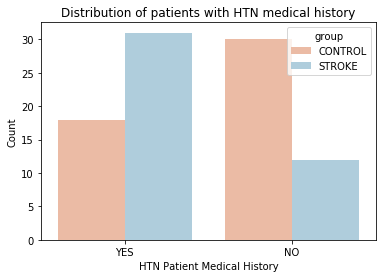

group    htn_patient_medical_history
CONTROL  NO                             30
         YES                            18
STROKE   YES                            31
         NO                             12
Name: htn_patient_medical_history, dtype: int64

In [6]:
#generate a countplot to visualise
#whether patients with hypertension medical history were more likely to suffer from stroke


#tidy up the column values 
new_df.loc[:, 'htn_patient_medical_history'] = new_df['htn_patient_medical_history'].apply(lambda x: x.upper()) 
new_df.loc[:, 'htn_patient_medical_history'] = new_df['htn_patient_medical_history'].str.replace(" ","")

#plot the figure
plt.figure()
sns.countplot(x='htn_patient_medical_history', hue='group', data=new_df, palette='RdBu')
plt.xlabel("HTN Patient Medical History")
plt.ylabel("Count")
plt.title("Distribution of patients with HTN medical history")
plt.show()

#the plot shows that more patients with stroke had hypertension medical history 
#than the control group

new_df.groupby('group')['htn_patient_medical_history'].value_counts()


<Figure size 432x288 with 0 Axes>

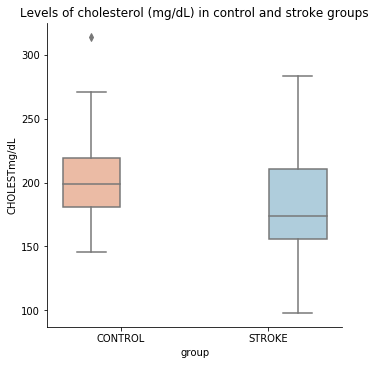

In [7]:
#high cholesterol is reported to be a risk factor for stroke. 

#plot the figure
plt.figure()
sns.catplot(y='CHOLESTmg/dL', x='group', hue='group', data=new_df, palette='RdBu', kind='box')
plt.ylabel("CHOLESTmg/dL")
plt.title("Levels of cholesterol (mg/dL) in control and stroke groups")
plt.show()

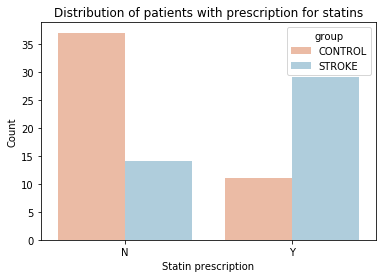

In [8]:

#plot the figure
plt.figure()
sns.countplot(x='STATINS', hue='group', data=new_df, palette='RdBu')
plt.xlabel("Statin prescription")
plt.ylabel("Count")
plt.title("Distribution of patients with prescription for statins")
plt.show()

<Figure size 432x288 with 0 Axes>

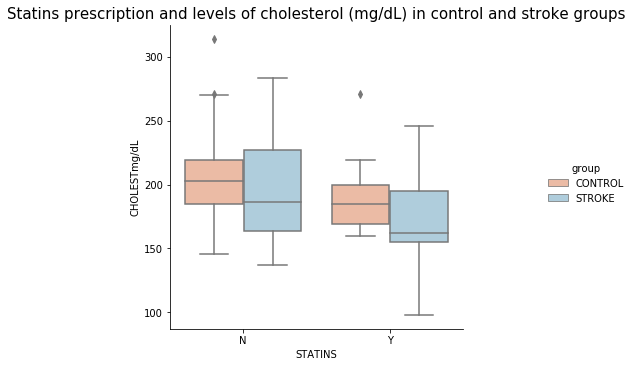

In [9]:
#The levels of cholesterol are lower in the stroke group. 
#Visualise whether medication use (e.g. statins) has an effect on this
#plot the figure
plt.figure()
sns.catplot(y='CHOLESTmg/dL', x='STATINS', hue='group', data=new_df, palette='RdBu', kind='box')
plt.ylabel("CHOLESTmg/dL")
plt.title("Statins prescription and levels of cholesterol (mg/dL) in control and stroke groups", size=15)
plt.show()



In [10]:
#Drop columns with missing data. 

df_dropped = new_df.dropna(axis=1)
df_dropped.info()

#dropping features with missing values reduced the number of columns almost ten-fold. 
#Most of columns are now object dtype, so this does not mean that there are no non-missing values too.


#BUT: dropping the data dropped celebral vasoregulation data.
#Alternative would be to impute the data using column statistisc

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Data columns (total 48 columns):
subject_number                           91 non-null object
completed_visit_status                   91 non-null object
htn_patient_medical_history              91 non-null object
group                                    91 non-null object
group2                                   91 non-null object
age                                      91 non-null int64
height/m                                 91 non-null float64
mass/kg                                  91 non-null float64
bmi                                      91 non-null float64
gender                                   91 non-null object
ethnicity                                91 non-null object
race                                     91 non-null object
DM Non-DM STROKE                         91 non-null object
previous_tobacco_use                     91 non-null object
PREVIOUS ALCOHOL USE                     91 non-null o

In [11]:
#create a new df without the object dtype values
df_ = new_df.select_dtypes(exclude=['object']).copy()

#fill the missing values with the mean
df_mn = df_.apply(lambda x: x.fillna(x.mean()),axis=0)

df_mn.info()
df_mn.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Columns: 375 entries, age to Clinical-WMHs punctuate-max Frontal-L
dtypes: float64(373), int64(2)
memory usage: 267.3 KB


,age,height/m,mass/kg,bmi,pack_years,years,ALCOHOL Dose/Week,HTN YRS PATIENT MEDICAL HISTORY,NIHSS,MRS,...,Clinical-WMHs punctuate-max Cortical-L,Clinical-WMHs punctuate-sum Cortical-L,Clinical-WMHs punctuate-average Cortical-L,Clinical-WMHs punctuate-max Cortical-R,Clinical-WMHs punctuate-sum Cortical-R,Clinical-WMHs punctuate-average Cortical-R,Clinical-WMHs continuous-max Frontal-L,Clinical-WMHs continuous-sum Frontal-L,Clinical-WMHs continuous-average Frontal-L,Clinical-WMHs punctuate-max Frontal-L
1,64,1.6256,72.574779,27.463655,0.0,0.0,0.0,4.000000,2.666667,1.195122,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0
3,74,1.7018,68.038856,23.493080,40.0,40.0,2.0,0.000000,2.666667,1.195122,...,7.0,9.0,4.5,6.0,8.0,4.0,2.0,8.0,1.6,0
4,76,1.7018,68.038856,23.493080,0.0,0.0,0.0,43.315789,2.666667,1.195122,...,1.0,2.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0
5,70,1.6764,68.492448,24.371788,0.0,0.0,7.0,0.000000,2.666667,1.195122,...,1.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,1.0,0
6,79,1.5748,64.863709,26.154774,0.0,0.0,0.0,0.000000,2.666667,1.195122,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,0


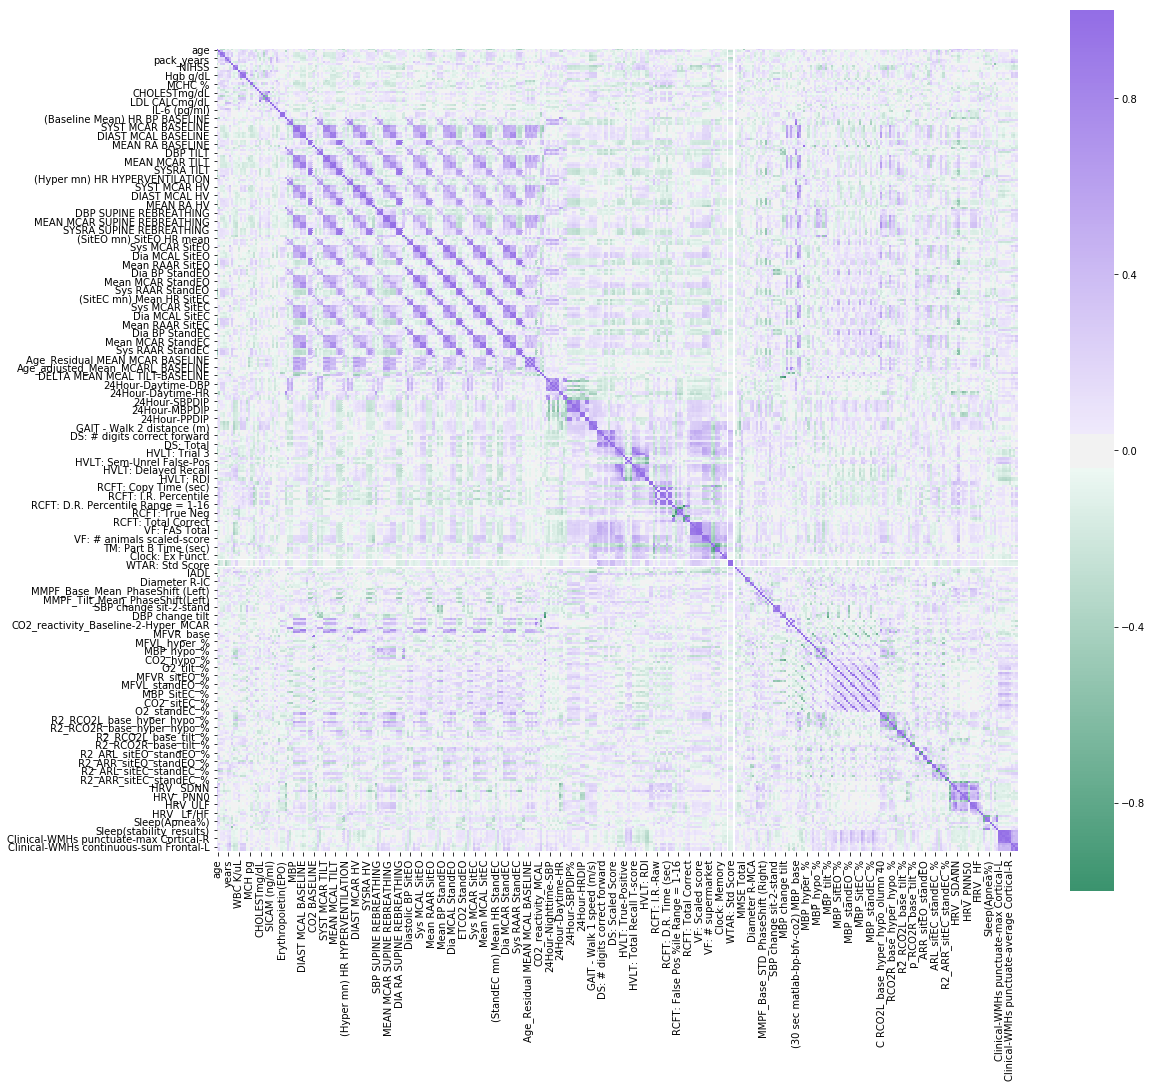

In [12]:
# First attempt to visualise the correlations between the features using the heatmap.
# Compute the correlation matrix
corr = df_mn.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .9})


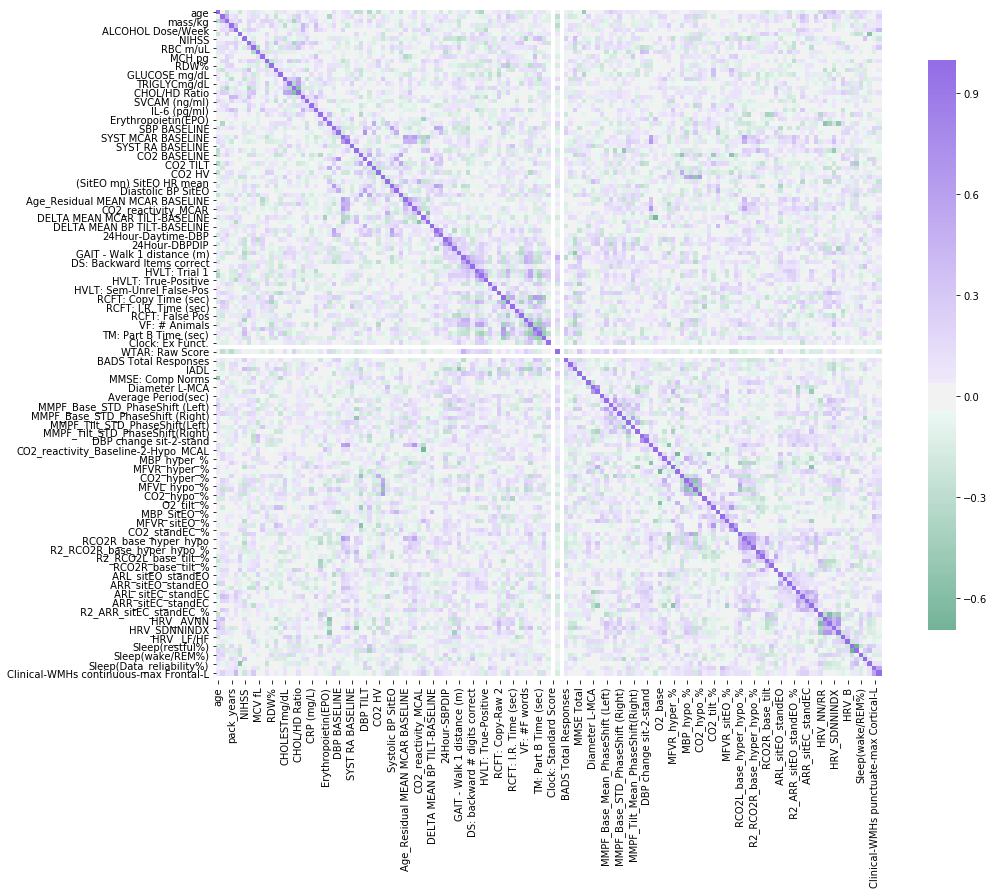

In [13]:
# Create correlation matrix
corr_matrix = df_mn.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop those columns from the DataFrame
df_drop = df_mn.drop(to_drop, axis=1)

df_drop.head()

corr_drop = df_drop.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_drop, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .7})

In [14]:
# Create a group labels dataset (these are the targets / labels to predict)
data_y = new_df[['group']]

#select categorical (object dtype) features
obj_df = new_df.select_dtypes(include=['object']).copy()

#drop group, subject_number and completed_visit_status columns 
obj_df = obj_df.drop(columns=['subject_number', 'completed_visit_status', 'group', 'group2'])

#make sure all entries like 'YES' and 'yes' are counted the same by making everything uppercase
obj_df_u = obj_df.apply(lambda x: x.str.upper() if x.dtype == "object" else x)  

obj_df.info()

#encode categorical values using pandas get_dummies() function
obj_df = pd.get_dummies(obj_df_u)

obj_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Data columns (total 64 columns):
htn_patient_medical_history                                  91 non-null object
gender                                                       91 non-null object
ethnicity                                                    91 non-null object
race                                                         91 non-null object
DM Non-DM STROKE                                             91 non-null object
previous_tobacco_use                                         91 non-null object
current_tobacco_use                                          90 non-null object
PREVIOUS ALCOHOL USE                                         91 non-null object
Neuropathy AUTONOMIC SYMPTOMS                                90 non-null object
Dizziness AUTONOMIC SYMPTOMS                                 91 non-null object
Numbness AUTONOMIC SYMPTOMS                                  91 non-null object
Painful feet AUT

,htn_patient_medical_history_NO,htn_patient_medical_history_YES,gender_F,gender_M,ethnicity_H/L,ethnicity_NON H/L,ethnicity_NON-H/L,ethnicity_UNKNOWN,race_AA,race_AFRICAN AMERICAN,...,RCFT: True Pos %ile Range = 1-16_0.9,RCFT: True Pos %ile Range = 1-16_10-JUN,RCFT: True Pos %ile Range = 1-16_13.5,RCFT: True Pos %ile Range = 1-16_17,RCFT: True Pos %ile Range = 1-16_3.5,RCFT: True Pos %ile Range = 1-16_8,TOF image available_NO,TOF image available_YES,TCD Yes/No_NO,TCD Yes/No_YES
1,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,1,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,1
5,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


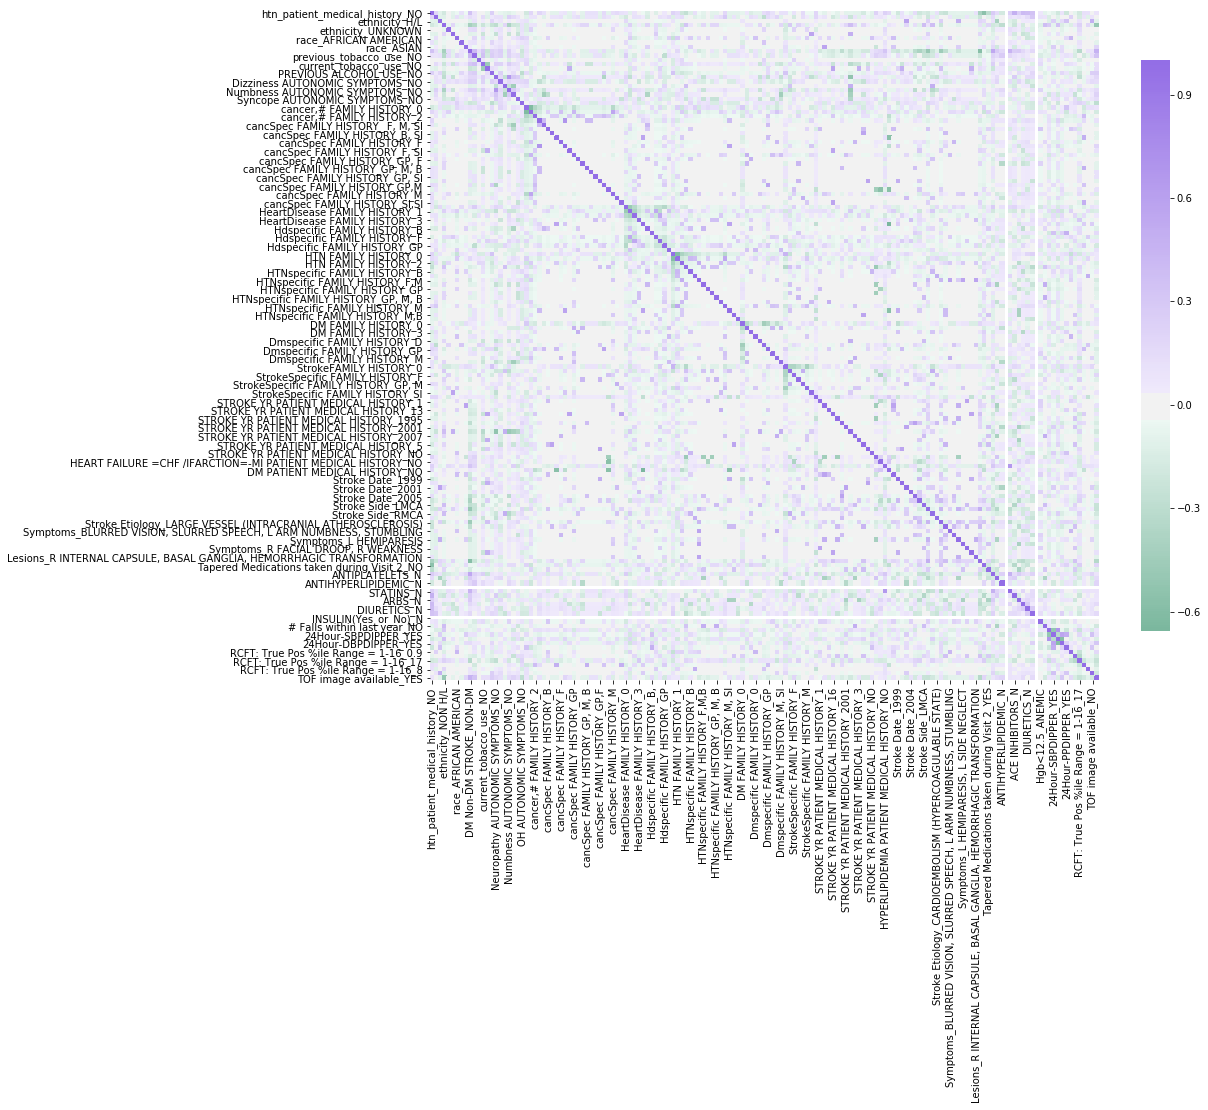

In [15]:
# Create correlation matrix
corr_matrix_o = obj_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_o.where(np.triu(np.ones(corr_matrix_o.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop those columns from the DataFrame
df_drop_o = obj_df.drop(to_drop, axis=1)

df_drop_o.head()


corr_drop = df_drop_o.corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_drop, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .7})

In [16]:
#merge the two data sets back together 

data_X = pd.concat([df_mn, obj_df], axis=1)

#drop object type columns
data_X = data_X.select_dtypes(exclude=['object']).copy()

#print data types in the dataset to ensure onbject class was removed.
data_X.dtypes
data_X.info()


#create smaller dataset with highly correlated features removed
data_X_drop = pd.concat([df_drop,  df_drop_o], axis=1)
data_X_drop.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Columns: 736 entries, age to TCD Yes/No_YES
dtypes: float64(373), int64(2), uint8(361)
memory usage: 299.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Columns: 305 entries, age to TOF image available_YES
dtypes: float64(148), int64(2), uint8(155)
memory usage: 121.1 KB


In [17]:
complete_df = pd.concat([data_y, data_X], axis=1)
complete_df.head()



,group,age,height/m,mass/kg,bmi,pack_years,years,ALCOHOL Dose/Week,HTN YRS PATIENT MEDICAL HISTORY,NIHSS,...,RCFT: True Pos %ile Range = 1-16_0.9,RCFT: True Pos %ile Range = 1-16_10-JUN,RCFT: True Pos %ile Range = 1-16_13.5,RCFT: True Pos %ile Range = 1-16_17,RCFT: True Pos %ile Range = 1-16_3.5,RCFT: True Pos %ile Range = 1-16_8,TOF image available_NO,TOF image available_YES,TCD Yes/No_NO,TCD Yes/No_YES
1,CONTROL,64,1.6256,72.574779,27.463655,0.0,0.0,0.0,4.000000,2.666667,...,0,0,0,0,0,0,1,0,0,1
3,CONTROL,74,1.7018,68.038856,23.493080,40.0,40.0,2.0,0.000000,2.666667,...,0,0,0,0,0,0,0,1,0,1
4,CONTROL,76,1.7018,68.038856,23.493080,0.0,0.0,0.0,43.315789,2.666667,...,0,0,0,1,0,0,0,1,0,1
5,CONTROL,70,1.6764,68.492448,24.371788,0.0,0.0,7.0,0.000000,2.666667,...,0,0,0,0,0,0,0,1,0,1
6,CONTROL,79,1.5748,64.863709,26.154774,0.0,0.0,0.0,0.000000,2.666667,...,0,0,0,0,0,0,0,1,0,1


In [18]:
#Check the variance of the column data to see if the data set needs normalisation
print(data_X.var())

# Print out the variance of the MCH pg (mean corpuscular volume) column
print(data_X['MCH pg'].var())

# Apply the log normalization function to the MCH pg column
data_X['HCH pg_log'] = np.log(data_X['MCH pg'])

# Check the variance of the MCH pg column again
print(data_X['HCH pg_log'].var())


# Print out the variance of the CHOLESTmg/dL (cholesterol) column
print(data_X['CHOLESTmg/dL'].var())

# Apply the log normalization function to the CHOLESTmg/dL column
data_X['CHOLESTmg/dL_log'] = np.log(data_X['CHOLESTmg/dL'])

# Check the variance of the CHOLESTmg/dL column again
print(data_X['CHOLESTmg/dL_log'].var())


# Print out the variance of the TRIGLYCmg/dL (triglyceride) column
print(data_X['TRIGLYCmg/dL'].var())

# Apply the log normalization function to the TRIGLYCmg/dL column
data_X['TRIGLYCmg/dL'] = np.log(data_X['TRIGLYCmg/dL'])

# Check the variance of the TRIGLYCmg/dL column again
print(data_X['TRIGLYCmg/dL'].var())



# Print out the variance of the SVCAM (ng/ml) (soluble- vascular adhesion molecule) column
print(data_X['SVCAM (ng/ml)'].var())

# Apply the log normalization function to the SVCAM (ng/ml) column
data_X['SVCAM (ng/ml)'] = np.log(data_X['SVCAM (ng/ml)'])

# Check the variance of the SVCAM (ng/ml) column again
print(data_X['SVCAM (ng/ml)'].var())

age                                            59.629060
height/m                                        0.007838
mass/kg                                       190.339739
bmi                                            18.928316
pack_years                                    723.909345
years                                         311.347190
ALCOHOL Dose/Week                             108.743968
HTN YRS PATIENT MEDICAL HISTORY             43439.247953
NIHSS                                           3.325926
MRS                                             0.560434
WBC K/uL                                        3.549636
RBC m/uL                                        0.170324
Hgb g/dL                                        1.747316
Hct %                                          12.475126
MCV fL                                         16.153846
MCH pg                                        965.804525
MCHC %                                          1.163639
RDW%                           

In [19]:
#'HTN YRS PATIENT MEDICAL HISTORY' looks suspicious in terms of variance

data_X['HTN YRS PATIENT MEDICAL HISTORY'].describe()

#get index for that particular row with unlikely number
data_X[data_X['HTN YRS PATIENT MEDICAL HISTORY']==2001.000000].index.item()

data_X.set_value(157, 'HTN YRS PATIENT MEDICAL HISTORY', data_X['HTN YRS PATIENT MEDICAL HISTORY'].mean()) 

data_X['HTN YRS PATIENT MEDICAL HISTORY'].describe()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


count    91.000000
mean     21.802776
std      19.689016
min       0.000000
25%       2.000000
50%      16.000000
75%      43.315789
max      50.000000
Name: HTN YRS PATIENT MEDICAL HISTORY, dtype: float64

In [20]:
#QC to ensure all NaN values are drop in the final datasets

print(type(data_y))
data_y.info()

print(type(data_X))
data_X.info()

print(data_X.isnull().values.any())

print(data_X.columns[data_X.isnull().any()].tolist())

data_X = data_X.dropna(axis=1)
data_X.info()
data_X.head()


data_X_drop = data_X_drop.dropna(axis=1)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Data columns (total 1 columns):
group    91 non-null object
dtypes: object(1)
memory usage: 3.9+ KB
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Columns: 738 entries, age to CHOLESTmg/dL_log
dtypes: float64(375), int64(2), uint8(361)
memory usage: 303.3 KB
True
['Clock: Standard Score', 'NIS Self-Report Form Total Response']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 164
Columns: 736 entries, age to CHOLESTmg/dL_log
dtypes: float64(373), int64(2), uint8(361)
memory usage: 301.9 KB


In [21]:
# Import the necessary modules for model building
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [27]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_X, np.ravel(data_y), stratify=data_y)

# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Score the model on the test data.
print(logreg.score(X_test, y_test))


#how good is my model? 
#test other metrics, such as confusion matrix (how many of samples are true positives and negatives?) 
#true positive = tp; true negative = tn; false positive = fp; false negative = fn
#classification_report gives information about
#precision (precision = tp/(tp+fp), here number of correctly labelled stroke patients), 
#recall(recall = tp(tp+fn); also called sensitivity, true positive rate)
# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



0.782608695652174
[[10  2]
 [ 3  8]]
              precision    recall  f1-score   support

     CONTROL       0.77      0.83      0.80        12
      STROKE       0.80      0.73      0.76        11

   micro avg       0.78      0.78      0.78        23
   macro avg       0.78      0.78      0.78        23
weighted avg       0.78      0.78      0.78        23



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_X, np.ravel(data_y), stratify=data_y)

# Fit the pipeline to the training set: logreg_scaled
logreg_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a logreg classifier to the unscaled data
logreg_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(logreg_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(logreg_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.9130434782608695
Accuracy without Scaling: 0.6086956521739131


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all convert

In [33]:
#Logreg fitting on reduced dataset (data_X_drop)
#Include scaling 


# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('logreg', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_X_drop, np.ravel(data_y), stratify=data_y)

# Fit the pipeline to the training set: logreg_scaled
logreg_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a logreg classifier to the unscaled data
logreg_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(logreg_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(logreg_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.9130434782608695
Accuracy without Scaling: 0.8260869565217391


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all convert